## DSCC202-402 Data Science at Scale Final Project
### Tracking Tweet sentiment at scale using a pretrained transformer (classifier)
<p>Consider the following illustration of the end to end system that you will be building.  Each student should do their own work.  The project will demonstrate your understanding of Spark Streaming, the medalion data architecture using Delta Lake, Spark Inference at Scale using an MLflow packaged model as well as Exploritory Data Analysis and System Tracking and Monitoring.</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/pipeline.drawio.png">

<p>
You will be pulling an updated copy of the course GitHub repositiory: <a href="https://github.com/lpalum/dscc202-402-spring2024">The Repo</a>.  If you are unclear on how to pull an updated copy using the GitHub command line, the following <a href="https://techwritingmatters.com/how-to-update-your-forked-repository-on-github">document</a> is helpful.  Be sure to add the professors and TAs as collaborators on your project. 

- lpalum@gmail.com GitHub ID: lpalum
- ajay.anand@rochester.edu GitHub ID: ajayan12
- divyamunot1999@gmail.com GitHub ID: divyamunot
- ylong6@u.Rochester.edu GitHub ID: NinaLong2077

Once you have updates your fork of the repository you should see the following template project that is resident in the final_project directory.
</p>

<img src="https://data-science-at-scale.s3.amazonaws.com/images/notebooks.drawio.png">

<p>
You can then pull your project into the Databrick Workspace using the <a href="https://www.databricks.training/step-by-step/importing-courseware-from-github/index.html">Repos</a> feature.
Each student is expected to submit the URL of their project on GitHub with their code checked in on the main/master branch.  This illustration highlights the branching scheme that you may use to work on your code in steps and then merge your submission into your master branch before submitting.
</p>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/github.drawio.png">
<p>
Work your way through this notebook which will give you the steps required to submit a complete and compliant project.  The following illustration and associated data dictionary specifies the transformations and data that you are to generate for each step in the medallion pipeline.
</p>
<br><br>
<img src="https://data-science-at-scale.s3.amazonaws.com/images/dataframes.drawio.png">

#### Bronze Data - raw ingest
- date - string in the source json
- user - string in the source json
- text - tweet string in the source json
- sentiment - the given sentiment of the text as determined by an unknown model that is provided in the source json
- source_file - the path of the source json file the this row of data was read from
- processing_time - a timestamp of when you read this row from the source json

#### Silver Data - Bronze Preprocessing
- timestamp - convert date string in the bronze data to a timestamp
- mention - every @username mentioned in the text string in the bronze data gets a row in this silver data table.
- cleaned_text - the bronze text data with the mentions (@username) removed.
- sentiment - the given sentiment that was associated with the text in the bronze table.

#### Gold Data - Silver Table Inference
- timestamp - the timestamp from the silver data table rows
- mention - the mention from the silver data table rows
- cleaned_text - the cleaned_text from the silver data table rows
- sentiment - the given sentiment from the silver data table rows
- predicted_score - score out of 100 from the Hugging Face Sentiment Transformer
- predicted_sentiment - string representation of the sentiment
- sentiment_id - 0 for negative and 1 for postive associated with the given sentiment
- predicted_sentiment_id - 0 for negative and 1 for positive assocaited with the Hugging Face Sentiment Transformer

#### Application Data - Gold Table Aggregation
- min_timestamp - the oldest timestamp on a given mention (@username)
- max_timestamp - the newest timestamp on a given mention (@username)
- mention - the user (@username) that this row pertains to.
- negative - total negative tweets directed at this mention (@username)
- neutral - total neutral tweets directed at this mention (@username)
- positive - total positive tweets directed at this mention (@username)

When you are designing your approach, one of the main decisions that you will need to make is how you are going to orchestrate the streaming data processing in your pipeline.  There are several valid approaches.  First, you may choose to start the bronze_stream and let it complete (read and append all of the source data) before preceeding and starting up the silver_stream.  This approach has latency associated with it but it will allow your code to proceed in a linear fashion and process all the data by the end of your notebook execution.  Another potential approach is to start all the streams and have a "watch" method to determine when the pipeline has processed sufficient or all of the source data before stopping and displaying results.  Both of these approaches are valid and have different implications on how you will trigger your steams and how you will gate the execution of your pipeline.  Think through how you want to proceed and ask questions if you need guidance. The following references may be helpful:
- [Spark Structured Streaming Programming Guide](https://spark.apache.org/docs/latest/structured-streaming-programming-guide.html)
- [Databricks Autoloader - Cloudfiles](https://docs.databricks.com/en/ingestion/auto-loader/index.html)

### Be sure that your project runs end to end when *Run all* is executued on this notebook! (15 Points out of 60)

In [0]:
%run ./includes/includes

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
petastorm 0.11.4 requires pyspark>=2.1.0, which is not installed.


Variable Name,Value,Description
TWEET_BUCKET_NAME,voc-75-databricks-data,AWS S3 Bucket Name where the tweets are coming into your system.
TWEET_BUCKET_URL,https://voc-75-databricks-data.s3.amazonaws.com/,AWS S3 Bucket URL where the tweets are coming into your system.
TWEET_SOURCE_PATH,s3a://voc-75-databricks-data/voc_volume/,AWS S3 Path where the tweets are coming into your system.
USER_DIR,/tmp/labuser104917-3032398/,Path to the local storage (dbfs) for your project.
BRONZE_CHECKPOINT,/tmp/labuser104917-3032398/bronze.checkpoint,Store your Bronze Checkpoint data here.
BRONZE_DELTA,/tmp/labuser104917-3032398/bronze.delta,Store your Bronze Delta Table here.
SILVER_CHECKPOINT,/tmp/labuser104917-3032398/silver.checkpoint,Store your Silver Checkpoint data here.
SILVER_DELTA,/tmp/labuser104917-3032398/silver.delta,Store your Silver Delta Table here.
GOLD_CHECKPOINT,/tmp/labuser104917-3032398/gold.checkpoint,Store your Gold Checkpoint data here.
GOLD_DELTA,/tmp/labuser104917-3032398/gold.delta,Store your Gold Delta Table here.


the includes are included


In [0]:
"""
Adding a widget to the notebook to control the clearing of a previous run.
or stopping the active streams using routines defined in the utilities notebook
"""
dbutils.widgets.removeAll()

dbutils.widgets.dropdown("clear_previous_run", "No", ["No","Yes"])
if (getArgument("clear_previous_run") == "Yes"):
    clear_previous_run()
    print("Cleared all previous data.")

dbutils.widgets.dropdown("stop_streams", "No", ["No","Yes"])
if (getArgument("stop_streams") == "Yes"):
    stop_all_streams()
    print("Stopped all active streams.")

# Add widget to control the Step 8 plotting loop
dbutils.widgets.dropdown("update_plots", "Yes", ["Yes", "No"], "Update Plots")

from delta import *
dbutils.widgets.dropdown("optimize_tables", "No", ["No","Yes"])
if (getArgument("optimize_tables") == "Yes"):
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, BRONZE_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, SILVER_DELTA).optimize().executeCompaction()
    # Suck up those small files that we have been appending.
    DeltaTable.forPath(spark, GOLD_DELTA).optimize().executeCompaction()
    print("Optimized all of the Delta Tables")

## 1.0 Import your libraries here...
- Are your shuffle partitions consistent with your cluster and your workload?
- Do you have the necessary libraries to perform the required operations in the pipeline/application?

In [0]:
# ENTER YOUR CODE HERE
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf
from pyspark.sql.functions import col, lit, when, udf, isnan, count, desc,input_file_name, current_timestamp, explode, regexp_replace, to_timestamp, expr
from pyspark.sql.types import IntegerType, StringType, DoubleType, StructType, StructField, StringType, TimestampType
from pyspark.sql.session import SparkSession
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
from sklearn.metrics import confusion_matrix, classification_report
from IPython.display import clear_output
import pyspark.sql.functions as F
import matplotlib.pyplot as plt
import seaborn as sns
import time
import boto3, botocore
import pandas as pd
import mlflow

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("TweetSentimentAnalysis") \
    .getOrCreate()

# Configuration for Spark to optimize shuffle partitions
spark.conf.set("spark.sql.shuffle.partitions", "200")

# Initialize the Hugging Face pipeline for sentiment analysis
sentiment_pipeline = pipeline("sentiment-analysis", model="finiteautomata/bertweet-base-sentiment-analysis")

print("Libraries and Spark session configured.")


/local_disk0/.ephemeral_nfs/envs/pythonEnv-c725c3de-cfe7-4995-ac19-2bbf9b27ac70/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/949 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/540M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/338 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/843k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/22.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/167 [00:00<?, ?B/s]

Libraries and Spark session configured.


## 2.0 Use the utility functions to ...
- Read the source file directory listing
- Count the source files (how many are there?)
- print the contents of one of the files

In [0]:
# Return a data frame with the files in the source directory
def get_source_listing_df() -> pd.DataFrame:
    # Create a boto3 resource for S3 using anonymous credentials
    s3 = boto3.resource('s3', config=boto3.session.Config(signature_version=botocore.UNSIGNED))

    # Create a Bucket object
    bucket = s3.Bucket(TWEET_BUCKET_NAME)

    # List objects in the bucket
    objects = [obj.key for obj in bucket.objects.all()]

    # Convert the list of objects to a Pandas DataFrame
    df = pd.DataFrame(objects, columns=['File Name'])

    return df

# Show the contents of a file stored in S3
def show_s3_file_contents(filename: str) -> str:
    # Create a boto3 resource for S3 using anonymous credentials
    s3 = boto3.resource('s3', config=boto3.session.Config(signature_version=botocore.UNSIGNED))
    # Show the first record
    obj = s3.Object(TWEET_BUCKET_NAME, filename)
    data=obj.get()['Body'].read()
    return(data)

# This routine requires the paths defined in the includes notebook
# and it clears data from the previous run.
def clear_previous_run() -> bool:
    # delete previous run 
    dbutils.fs.rm(BRONZE_CHECKPOINT, True)
    dbutils.fs.rm(BRONZE_DELTA, True)
    dbutils.fs.rm(SILVER_CHECKPOINT, True)
    dbutils.fs.rm(SILVER_DELTA, True)
    dbutils.fs.rm(GOLD_CHECKPOINT, True)
    dbutils.fs.rm(GOLD_DELTA, True)
    return True

def stop_all_streams() -> bool:
    stopped = False
    for stream in spark.streams.active:
        stopped = True
        stream.stop()
    return stopped


def stop_named_stream(spark: SparkSession, namedStream: str) -> bool:
    stopped = False
    for stream in spark.streams.active:
        if stream.name == namedStream:
            stopped = True 
            stream.stop()
    return stopped

def wait_stream_start(spark: SparkSession, namedStream: str) -> bool:
    started = False
    count = 0
    if started == False and count <= 3:
        for stream in spark.streams.active:
            if stream.name == namedStream:
                started = True
        count += 1
        time.sleep(10)
    return started    

In [0]:
# ENTER YOUR CODE HERE

# Read the source file directory listing
source_files_df = get_source_listing_df()
print("Directory Listing:")
print(source_files_df)

# Count the source files
file_count = len(source_files_df)
print("Number of source files:", file_count)

# Print the contents of the first file
if file_count > 0:
    first_file_name = source_files_df.iloc[0]['File Name']
    print("Contents of the first file:")
    file_contents = show_s3_file_contents(first_file_name)
    print(file_contents)
else:
    print("No files found in the source directory.")


Directory Listing:
                    File Name
0           voc_volume/0.json
1           voc_volume/1.json
2          voc_volume/10.json
3         voc_volume/100.json
4        voc_volume/1000.json
...                       ...
199996  voc_volume/99995.json
199997  voc_volume/99996.json
199998  voc_volume/99997.json
199999  voc_volume/99998.json
200000  voc_volume/99999.json

[200001 rows x 1 columns]
Number of source files: 200001
Contents of the first file:
b'{"date": "Mon Apr 06 22:19:45 PDT 2009", "user": "_TheSpecialOne_", "text": "@switchfoot http://twitpic.com/2y1zl - Awww, that\'s a bummer.  You shoulda got David Carr of Third Day to do it. ;D", "sentiment": "negative"}'


## 3.0 Transform the Raw Data to Bronze Data using a stream
- define the schema for the raw data
- setup a read stream using cloudfiles and the source data format
- setup a write stream using cloudfiles to append to the bronze delta table
- enforce schema
- allow a new schema to be merged into the bronze delta table
- Use the defined BRONZE_CHECKPOINT and BRONZE_DELTA paths defines in the includes
- name your raw to bronze stream as bronze_stream
- transform the raw data to the bronze data using the data definition at the top of the notebook

In [0]:
# ENTER YOUR CODE HERE

# Define the schema based on the JSON structure
schema = StructType([
    StructField("date", StringType(), True),
    StructField("user", StringType(), True),
    StructField("text", StringType(), True),
    StructField("sentiment", StringType(), True)
])

# Setup a Read Stream
raw_stream = spark.readStream \
    .format("cloudFiles") \
    .option("cloudFiles.format", "json") \
    .schema(schema) \
    .load(TWEET_SOURCE_PATH)

bronze_df = raw_stream \
    .withColumn("source_file", input_file_name()) \
    .withColumn("processing_time", current_timestamp())

# Start the Stream
bronze_stream = bronze_df.writeStream \
    .format("delta") \
    .option("checkpointLocation", BRONZE_CHECKPOINT) \
    .option("path", BRONZE_DELTA) \
    .outputMode("append") \
    .queryName("bronze_stream") \
    .start()


In [0]:
# In order to load the stream output data, I set aside enough time to ensure the successful execution of following cells
time.sleep(30)

# Check for Bronze Table
bronze_df = spark.read.format("delta").load(BRONZE_DELTA)
bronze_df.show()

+--------------------+---------------+--------------------+---------+--------------------+--------------------+
|                date|           user|                text|sentiment|         source_file|     processing_time|
+--------------------+---------------+--------------------+---------+--------------------+--------------------+
|Sat Apr 18 21:44:...| YouGoNormaCoco|Tanned and had di...| negative|s3a://voc-75-data...|2024-05-11 19:36:...|
|Sat Apr 18 21:32:...|      quagliato|Acabando agora o ...| positive|s3a://voc-75-data...|2024-05-11 19:36:...|
|Sat Apr 18 21:44:...|sicknastyalison|I still like the ...| negative|s3a://voc-75-data...|2024-05-11 19:36:...|
|Sat Apr 18 21:51:...|cartercountry92|@Bobby_Labonte. u...| negative|s3a://voc-75-data...|2024-05-11 19:36:...|
|Sat Apr 18 21:42:...|sputnikSweethrt|@SquashBlossom Fl...| positive|s3a://voc-75-data...|2024-05-11 19:36:...|
|Sat Apr 18 21:57:...|    slimgoody05|Got sexual chocol...| positive|s3a://voc-75-data...|2024-05-11 19:

## 4.0 Bronze Data Exploratory Data Analysis
- How many tweets are captured in your Bronze Table?
- Are there any columns that contain Nan or Null values?  If so how many and what will you do in your silver transforms to address this?
- Count the number of tweets by each unique user handle and sort the data by descending count.
- How many tweets have at least one mention (@) how many tweet have no mentions (@)
- Plot a bar chart that shows the top 20 tweeters (users)


In [0]:
# ENTER YOUR CODE
# Count Tweets in the Bronze Table
tweet_count = spark.read.format("delta").load(BRONZE_DELTA).count()
print(f"Number of tweets in the Bronze Table: {tweet_count}")

Number of tweets in the Bronze Table: 200000


In [0]:
# Identify and Address Null Values
bronze_df = spark.read.format("delta").load(BRONZE_DELTA)
null_counts = bronze_df.select([count(when(col(c).isNull(), c)).alias(c) for c in bronze_df.columns])
null_counts.show()

+----+----+----+---------+-----------+---------------+
|date|user|text|sentiment|source_file|processing_time|
+----+----+----+---------+-----------+---------------+
|   0|   0|   0|        0|          0|              0|
+----+----+----+---------+-----------+---------------+



In [0]:
# Count Tweets by Each User Handle
user_tweet_counts = bronze_df.groupBy("user").count().orderBy(desc("count"))
user_tweet_counts.show()

# Count Tweets with Mentions
mentions_count = bronze_df.withColumn("has_mention", when(col("text").contains("@"), 1).otherwise(0))
mention_stats = mentions_count.groupBy("has_mention").count()
mention_stats.show()

+---------------+-----+
|           user|count|
+---------------+-----+
|       tweetpet|  310|
|     nuttychris|  129|
|      iHomeTech|   81|
|       tsarnick|   77|
| Hollywood_Trey|   71|
|  divxdownloads|   68|
|      lesley007|   65|
|  redrobinrockn|   58|
|    MissxMarisa|   57|
|     SarahSaner|   56|
|     sebby_peek|   55|
|        kasey79|   54|
|torilovesbradie|   51|
|    whitsundays|   51|
|         keza34|   49|
| MiDesfileNegro|   48|
|        Dogbook|   47|
|   TraceyHewins|   46|
|    effingcards|   43|
|         Djalfy|   43|
+---------------+-----+
only showing top 20 rows

+-----------+------+
|has_mention| count|
+-----------+------+
|          1| 93817|
|          0|106183|
+-----------+------+



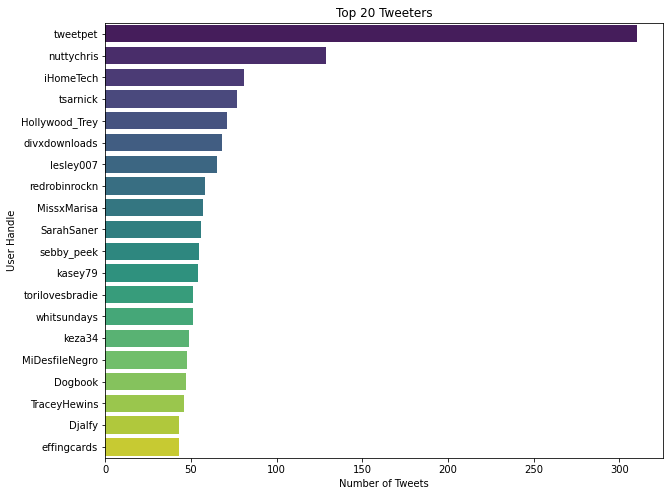

In [0]:
# Plot a Bar Chart of the Top 20 Tweeters
top_tweeters = user_tweet_counts.toPandas().head(20)
plt.figure(figsize=(10, 8))
sns.barplot(x='count', y='user', data=top_tweeters, palette='viridis')
plt.title('Top 20 Tweeters')
plt.xlabel('Number of Tweets')
plt.ylabel('User Handle')
plt.show()

## 5.0 Transform the Bronze Data to Silver Data using a stream
- setup a read stream on your bronze delta table
- setup a write stream to append to the silver delta table
- Use the defined SILVER_CHECKPOINT and SILVER_DELTA paths in the includes
- name your bronze to silver stream as silver_stream
- transform the bronze data to the silver data using the data definition at the top of the notebook

In [0]:
# ENTER YOUR CODE HERE

# Read from the Bronze Delta table
bronze_df = spark.readStream.format("delta").load(BRONZE_DELTA)
spark.conf.set("spark.sql.legacy.timeParserPolicy", "LEGACY")

# Define transformation for Silver Data
silver_df = bronze_df \
    .withColumn("timestamp", to_timestamp("date", "EEE MMM dd HH:mm:ss zzz yyyy")) \
    .withColumn("mentions", expr("filter(split(text, ' '), x -> x like '@%')")) \
    .withColumn("mention", explode("mentions")) \
    .withColumn("cleaned_text", regexp_replace("text", "@\\S+", "")) \
    .select(
        "timestamp",
        "mention",
        "cleaned_text",
        "sentiment"
    )

# Setup the write stream for the Silver Delta Table
silver_stream = silver_df.writeStream \
    .format("delta") \
    .option("checkpointLocation", SILVER_CHECKPOINT) \
    .option("path", SILVER_DELTA) \
    .outputMode("append") \
    .queryName("silver_stream") \
    .start()


In [0]:
# In order to load the stream output data, I set aside enough time to ensure the successful execution of following cells
time.sleep(120)

# Check for Silver Table
silver_df = spark.read.format("delta").load(SILVER_DELTA)
silver_df.show()

+-------------------+----------------+--------------------+---------+
|          timestamp|         mention|        cleaned_text|sentiment|
+-------------------+----------------+--------------------+---------+
|2009-05-03 13:29:35|           @rjsh|  Yes, &quot;serv...| positive|
|2009-05-03 13:29:35|@kenwilsonlondon|  Yes, &quot;serv...| positive|
|2009-05-03 13:29:26|@animalspiritsdr| I prayed for mer...| negative|
|2009-05-03 13:54:07|@AnimalRightsNow| Good4u~hate conc...| negative|
|2009-05-03 13:32:39|       @jasmooti| jas don't cry  t...| negative|
|2009-05-03 13:29:01|     @Squeakynee| ohhh BBQ wish I ...| negative|
|2009-04-07 12:54:27|    @DelphaForce| How'd you guess!...| negative|
|2009-05-03 13:29:37|     @babymakes7| That's interesti...| positive|
|2009-05-03 13:34:36|  @PensieveRobin| so glad you guys...| positive|
|2009-05-03 13:44:17|       @clara018| yeah omg i do to...| positive|
|2009-05-03 13:49:32|   @la_revanche:| idk if i can com...| negative|
|2009-05-03 13:28:49

## 6.0 Transform the Silver Data to Gold Data using a stream
- setup a read stream on your silver delta table
- setup a write stream to append to the gold delta table
- Use the defined GOLD_CHECKPOINT and GOLD_DELTA paths defines in the includes
- name your silver to gold stream as gold_stream
- transform the silver data to the gold data using the data definition at the top of the notebook
- Load the pretrained transformer sentiment classifier from the MODEL_NAME at the production level from the MLflow registry
- Use a spark UDF to parallelize the inference across your silver data

In [0]:
# ENTER YOUR CODE HERE
silver_df = spark.readStream.format("delta").load(SILVER_DELTA)

model_name = "finiteautomata/bertweet-base-sentiment-analysis"
model_pipeline = pipeline("sentiment-analysis", model=model_name)

@udf(returnType="struct<score:float, label:string>")
def sentiment_analysis(text):
    try:
        result = model_pipeline(text)[0]
        return (result['score'], result['label'])
    except Exception as e:
        return (None, None)

# Transform Silver Data to Gold Data
gold_df = silver_df \
    .withColumn("sentiment_analysis", sentiment_analysis(col("cleaned_text"))) \
    .withColumn("predicted_score", col("sentiment_analysis.score") * 100) \
    .withColumn("predicted_sentiment", col("sentiment_analysis.label")) \
    .withColumn("sentiment_id", when(col("sentiment") == "negative", 0).otherwise(1)) \
    .withColumn("predicted_sentiment_id", when(col("predicted_sentiment") == "NEGATIVE", 0).otherwise(1)) \
    .select(
        "timestamp",
        "mention",
        "cleaned_text",
        "sentiment",
        "predicted_score",
        "predicted_sentiment",
        "sentiment_id",
        "predicted_sentiment_id"
    )

# Setup stream to the Gold Delta Table
gold_stream = gold_df.writeStream \
    .format("delta") \
    .option("checkpointLocation", GOLD_CHECKPOINT) \
    .option("path", GOLD_DELTA) \
    .outputMode("append") \
    .queryName("gold_stream") \
    .start()

/local_disk0/.ephemeral_nfs/envs/pythonEnv-c725c3de-cfe7-4995-ac19-2bbf9b27ac70/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [0]:
# In order to load the stream output data, I set aside enough time to ensure the successful execution of following cells
time.sleep(600)

# Check for Gold Table
gold_df = spark.read.format("delta").load(GOLD_DELTA)
gold_df.show()

+-------------------+----------------+--------------------+---------+---------------+-------------------+------------+----------------------+
|          timestamp|         mention|        cleaned_text|sentiment|predicted_score|predicted_sentiment|sentiment_id|predicted_sentiment_id|
+-------------------+----------------+--------------------+---------+---------------+-------------------+------------+----------------------+
|2009-05-02 07:15:05|     @chaunceycc| http://twitpic.c...| negative|       74.30921|                POS|           0|                     1|
|2009-05-02 07:16:21|    @LATHumphrey| I dedicated my d...| negative|      83.724556|                NEG|           0|                     1|
|2009-05-02 07:25:35|   @PumpkinPeazy| haha.First time ...| negative|       75.43863|                POS|           0|                     1|
|2009-05-02 07:35:45|   @NicolaWwilts| wow, you start e...| positive|       97.28787|                POS|           1|                     1|
|2009-

## 7.0 Capture the accuracy metrics from the gold table in MLflow
Store the following in an MLflow experiment run:
- Store the precision, recall, and F1-score as MLflow metrics
- Store an image of the confusion matrix as an MLflow artifact
- Store the model name and the MLflow version that was used as an MLflow parameters
- Store the version of the Delta Table (input-silver) as an MLflow parameter

In [0]:
# ENTER YOUR CODE HERE

# Convert to Pandas for evaluation
pdf = gold_df.select("sentiment_id", "predicted_sentiment_id").toPandas()

# Calculate metrics
report = classification_report(pdf['sentiment_id'], pdf['predicted_sentiment_id'], output_dict=True)
precision = report['weighted avg']['precision']
recall = report['weighted avg']['recall']
f1_score = report['weighted avg']['f1-score']

# Confusion Matrix
conf_matrix = confusion_matrix(pdf['sentiment_id'], pdf['predicted_sentiment_id'])

# Plot Confusion Matrix and Save as Image
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
confusion_matrix_path = "/tmp/confusion_matrix.png"
plt.savefig(confusion_matrix_path)
plt.close()

#  Start an MLflow Run to Log Metrics, Parameters, and Artifacts
delta_table_path = GOLD_DELTA 
latest_version = spark.sql(f"DESCRIBE HISTORY delta.`{delta_table_path}`").collect()[0]["version"]

with mlflow.start_run():
    # Log metrics
    mlflow.log_metric("Precision", precision)
    mlflow.log_metric("Recall", recall)
    mlflow.log_metric("F1 Score", f1_score)

    # Log confusion matrix as an artifact
    mlflow.log_artifact(confusion_matrix_path)

    # Log parameters
    mlflow.log_param("Model Name", model_name)
    mlflow.log_param("MLflow Version", mlflow.__version__)
    mlflow.log_param("Delta Table Version", latest_version)


/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/databricks/python/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## 8.0 Application Data Processing and Visualization
- How many mentions are there in the gold data total?
- Count the number of neutral, positive and negative tweets for each mention in new columns
- Capture the total for each mention in a new column
- Sort the mention count totals in descending order
- Plot a bar chart of the top 20 mentions with positive sentiment (the people who are in favor)
- Plot a bar chart of the top 20 mentions with negative sentiment (the people who are the vilians)

You may want to use the "Loop Application" widget to control whether you repeateded display the latest plots while the data comes in from your streams before moving on to the next section and cleaning up your run.

*note: A mention is a specific twitter user that has been "mentioned" in a tweet with an @user reference.

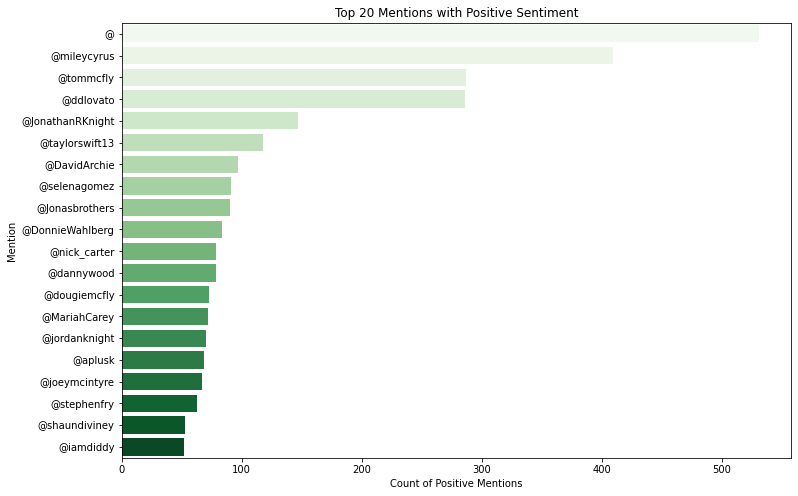

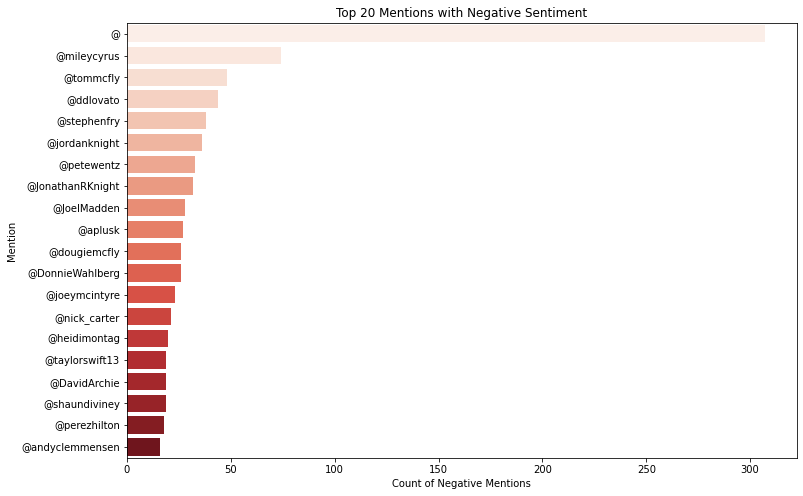

In [0]:
# ENTER YOUR CODE HERE

def update_data():
    # Load the gold data
    gold_df = spark.read.format("delta").load(GOLD_DELTA)

    # Aggregation by mention and sentiment
    mention_sentiment_counts = gold_df.groupBy("mention").pivot("predicted_sentiment").count()

    # Ensure the counts for all sentiments are available as columns, filling missing with 0
    mention_totals = mention_sentiment_counts.na.fill(0)

    # Adding a total count for each mention
    mention_totals = mention_totals.withColumn("Total", F.col("POS") + F.col("NEG") + F.col("NEU"))

    # Sort by the total counts in descending order
    sorted_mentions = mention_totals.orderBy(F.col("Total").desc())

    # Convert to Pandas DataFrame for visualization
    mention_pd = sorted_mentions.toPandas()

    return mention_pd

def plot_data(mention_pd):
    # Plotting top 20 mentions with positive sentiment
    top_positive_mentions = mention_pd.nlargest(20, 'POS')
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_positive_mentions, x='POS', y='mention', palette='Greens')
    plt.title('Top 20 Mentions with Positive Sentiment')
    plt.xlabel('Count of Positive Mentions')
    plt.ylabel('Mention')
    plt.show()

    # Plotting top 20 mentions with negative sentiment
    top_negative_mentions = mention_pd.nlargest(20, 'NEG')
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_negative_mentions, x='NEG', y='mention', palette='Reds')
    plt.title('Top 20 Mentions with Negative Sentiment')
    plt.xlabel('Count of Negative Mentions')
    plt.ylabel('Mention')
    plt.show()

# Check the widget's value to decide whether to continue updating
if dbutils.widgets.get("update_plots") == "Yes":
    mention_pd = update_data()
    clear_output(wait=True)
    plot_data(mention_pd)
else:
    # If the widget is not set to "Yes", wait when 'Yes' and check again
    print(f"Switch 'update_plots' widgets to 'Yes' to update the plots.")

## 9.0 Clean up and completion of your pipeline
- using the utilities what streams are running? If any.
- Stop all active streams
- print out the elapsed time of your notebook.

In [0]:
# ENTER YOUR CODE HERE
# Check the active streams
active_streams = spark.streams.active

for stream in active_streams:
    print(f"Stream Name: {stream.name}")
    print(f"Is Active: {stream.isActive}")
    print(f"Stream ID: {stream.id}")
    print("\n")
    
# Stop all streams
for stream in active_streams:
    stream.stop()

Stream Name: silver_stream
Is Active: True
Stream ID: 639a8ae2-85ee-4a62-99a8-9e001d6925ab


Stream Name: bronze_stream
Is Active: True
Stream ID: 3f36b022-effd-4cd3-bdd0-4c782662b85c


Stream Name: gold_stream
Is Active: True
Stream ID: 086db8a1-755a-41e7-a2ac-e404769175e4




In [0]:
# Get the notebooks ending time note START_TIME was established in the include file when the notebook started.
END_TIME = time.time()
TOTAL_TIME = END_TIME - START_TIME
print(f'It took {TOTAL_TIME} to run all the notebook')

It took 1110.3115820884705 to run all the notebook


## 10.0 How Optimized is your Spark Application (Grad Students Only)
Graduate students (registered for the DSCC-402 section of the course) are required to do this section.  This is a written analysis using the Spark UI (link to screen shots) that support your analysis of your pipelines execution and what is driving its performance.
Recall that Spark Optimization has 5 significant dimensions of considertation:
- Spill: write to executor disk due to lack of memory
- Skew: imbalance in partition size
- Shuffle: network io moving data between executors (wide transforms)
- Storage: inefficiency due to disk storage format (small files, location)
- Serialization: distribution of code segments across the cluster

Comment on each of the dimentions of performance and how your impelementation is or is not being affected.  Use specific information in the Spark UI to support your description.  

Note: you can take sreenshots of the Spark UI from your project runs in databricks and then link to those pictures by storing them as a publicly accessible file on your cloud drive (google, one drive, etc.)

References:
- [Spark UI Reference Reference](https://spark.apache.org/docs/latest/web-ui.html#web-ui)
- [Spark UI Simulator](https://www.databricks.training/spark-ui-simulator/index.html)

### ENTER YOUR MARKDOWN HERE

#### Shuffle

Screenshot link: https://drive.google.com/file/d/1OymtQ_ZnozJJZ_Z_rDs2k7Q-RyqSltft/view?usp=sharing

- The screenshot provides metrics into the shuffle behavior of tasks, a critical performance aspect of distributed computing. Specifically, the "Shuffle Read" and "Shuffle Write" columns are key indicators of how data is being transferred across the cluster, which is central to understanding the efficiency of data processing tasks that involve wide transformations such as joins, aggregations, or groupBy operations. In the displayed stages, there are varying amounts of shuffle data, with certain stages showing significant shuffle writes in the kilobytes range. For example, stage 912 evidences a shuffle write of approximately 6180 B alongside a corresponding shuffle read in a subsequent stage, indicating a transfer of intermediate data between stages. This pattern of shuffle activity suggests that the operations in these stages are likely causing a redistribution of data across the cluster's nodes, which can be a potential bottleneck if not managed properly. Moreover, the balance between shuffle read and write volumes across different stages offers insights into the data flow and processing chain within the application, where optimizing the shuffle process might involve minimizing unnecessary data transfers or improving the partitioning of data to reduce network overhead. Efficient management of shuffle can significantly impact the overall performance of Spark applications, as excessive shuffle can lead to increased network I/O, greater disk I/O when data spills over from memory, and ultimately, longer job execution times. Therefore, careful tuning of partitioning strategies and a thorough review of transformation operations are imperative to optimize shuffle behavior, ensuring a more efficient execution of distributed data processing tasks in Spark.

#### Serialization

Screenshot link: https://drive.google.com/file/d/1WDmq4GKEXrznlopCqiCWexSsXuLMtsVg/view?usp=sharing

- This screenshot from the Spark UI reveals detailed task performance metrics that primarily shed light on the dimension of Serialization, particularly focusing on task deserialization and result serialization times. The event timeline and summary metrics illustrate several vital aspects of how data and tasks are serialized and deserialized across Spark's distributed architecture. In the screenshot, the "Task Deserialization Time" and "Result Serialization Time" metrics are particularly relevant. The deserialization time, which refers to the time taken to convert byte streams back into Spark data structures at the executor side, shows a minimum and median around 9-10 ms, peaking at 16 ms. This indicates a relatively efficient deserialization process, suggesting that the overhead from this serialization aspect is minimal.

- However, even minimal serialization or deserialization times can accumulate significant delays in larger-scale operations, particularly when dealing with vast datasets or complex iterative algorithms where tasks are frequently serialized and deserialized. Efficient serialization processes are vital for minimizing these overheads, as poor serialization strategies can lead to increased data size, longer transmission times, and ultimately slower task execution. Result serialization, which involves converting computation results into a format suitable for transmission back to the driver or storage, shows minimal overhead in this instance, which is an ideal scenario in Spark operations.

- Optimizing serialization in Spark often involves choosing the right data formats and serialization libraries. For example, using Kryo serialization instead of Java serialization can significantly reduce serialization costs due to its superior performance and efficiency in handling large numbers of objects. Furthermore, minimizing the data that needs to be serialized — by filtering down to necessary fields before shuffling or caching data — can also reduce the impact of serialization on overall application performance.

- In summary, while the current serialization times shown do not suggest a significant bottleneck, continuous monitoring and optimization of serialization settings remain crucial for scaling applications efficiently. Adjustments such as tuning the Spark configuration for serialization, selecting efficient data structures, and considering the serialization format can lead to substantial performance gains in distributed computing environments like Spark.

#### Spill

Screenshot link: https://drive.google.com/file/d/1nw5hxn7H87U6lmcQQwfCjhwUxl6MbNzt/view?usp=sharing

- This screenshot displays a detailed overview of the Executors tab, specifically highlighting the utilization of resources such as storage memory, disk usage, and active tasks, which is closely tied to the dimension of Spill. The screenshot reveals that each executor has utilized a substantial amount of storage memory (approximately 10.4 GiB on heap) and also indicates disk usage (517.1 MiB). While the screenshot does not explicitly show memory spills, the use of disk space in the context of executors with considerable memory utilization suggests that spillage might be occurring, especially if the tasks involve large datasets or wide transformations that exceed the memory capacity assigned to each executor.

- Moreover, the fact that all the tasks are marked as completed successfully without any failures suggests that the system is managing to process the workload despite the potential high memory demand and possible spillage. However, the reliance on disk space indicates that optimizing memory management could potentially improve performance. Strategies to prevent or minimize spillage include increasing memory allocation to executors, optimizing the persistence levels of RDDs or DataFrames (e.g., choosing MEMORY_AND_DISK over MEMORY_ONLY), and adjusting the configuration settings like `spark.memory.fraction` and `spark.shuffle.compress` to better manage memory usage.

- In addition to hardware adjustments, software-level optimizations such as repartitioning data to ensure more uniform distribution among tasks or tuning the size of partitions to better fit the available memory can also help reduce the need for spillage. Analyzing the shuffle write and read metrics along with task deserialization time can provide further insights into how effectively data is being processed across the cluster and whether additional optimizations are necessary to reduce disk spillage and improve overall performance.

- These measures are crucial for maintaining efficiency and ensuring that Spark applications run optimally, particularly in environments handling large-scale data processing tasks. By continuously monitoring and adjusting the memory management configurations based on the workload characteristics and system performance, one can significantly mitigate the impact of spill-related issues on Spark applications.

#### Storage

Screenshot link: https://drive.google.com/file/d/11HwL_FoWxo5QbpMVUBq8dMSqNjdx2p2V/view?usp=sharing

- This screenshot gives detailed insights into how data is being stored and managed across the cluster. We see various metrics related to Parquet IO Cache, data read and written to the IO cache, and detailed information on RDD storage. The data shows that Parquet files are being utilized, which are known for their efficiency in both storage and read/write operations due to their columnar storage format. This format allows for better compression and encoding schemes, significantly enhancing data retrieval operations by enabling selective reads of only the necessary columns.

- Moreover, the metrics show a total disk usage well below the limit (24.8 MiB used out of 463.9 GiB available), indicating that the current data management strategy is highly effective without nearing storage capacity limits. This efficiency is further emphasized by the metadata cache usage, which is at 0% of its 9.3 GiB limit, suggesting that metadata operations are not consuming excessive resources, thus maintaining a lean operational profile.

- The efficient use of storage is further evidenced by the "Data Read from IO Cache" and "Data Written to IO Cache," indicating that Spark is effectively utilizing its caching mechanisms to speed up data access. The cache hit ratio at 64% suggests that over half of the read requests are served directly from the cache, reducing the need to access the disk frequently and thereby speeding up the data processing tasks. Additionally, the use of compressed data formats, as shown by the compressed read and write operations, helps in reducing the I/O operations' impact on the system’s overall performance. By minimizing the data footprint on disk and during transfers, Spark can operate more swiftly and scale more effectively when processing large datasets.

- In summary, the storage strategies employed here—leveraging efficient data formats like Parquet, optimizing cache usage, and ensuring data compression—are pivotal for enhancing the performance of Spark applications. These strategies reduce the load on the system resources, enable faster data processing, and ensure scalability, which are essential for handling big data applications efficiently. As Spark continues to handle larger and more complex datasets, maintaining and enhancing these storage strategies will be crucial for sustaining and improving performance.

#### Skew

Screenshot link: https://drive.google.com/file/d/18VOVYe_O3vnnnXaxcw3WjThb4314Is5W/view?usp=sharing

- This screenshot from the cluster report provides a comprehensive view of the system's performance metrics, mainly focusing on CPU load, memory usage, and network activity. Data skew refers to unequal distribution of data across partitions, which can lead to some nodes in the cluster being overburdened while others remain underutilized, impacting overall performance and efficiency.

- In the cluster report, while specific indicators of skew are not directly visible, we can infer potential skew issues from the "Server Load Distribution" and "Cluster CPU Last Hour" charts. These visualizations show the load and CPU usage across different times and nodes. If certain nodes consistently show higher CPU usage or load compared to others, it could suggest that those nodes are processing larger chunks of data or more complex operations, indicative of data skew. Additionally, the "Cluster Network Last Hour" graph shows spikes in network activity, which might be related to data being shuffled across the cluster to manage imbalanced loads, further hinting at possible skew issues.

- Properly addressing data skew involves strategies such as repartitioning the data more evenly across the cluster, increasing the level of parallelism, or applying custom partitioning logic to ensure a more uniform distribution of data. Techniques like salting keys to modify the data before applying 'groupBy' or 'join' operations can also help mitigate skew by breaking up large, concentrated datasets into more manageable parts.

- Understanding and rectifying data skew is crucial because it not only affects the performance of individual nodes but can also lead to increased execution times and resource wastage, as overburdened nodes slow down the entire computation process. Regular monitoring of these metrics, therefore, is essential to identify and correct skew early in the process, ensuring that resources are optimally utilized and performance bottlenecks are minimized. By continuously adjusting the data distribution strategies in response to observed performance metrics, Spark applications can achieve better scalability and efficiency, handling large-scale data processing tasks more effectively.